# PCI Query Flow with LangGraph
This notebook demonstrates a predictive customer intelligence flow using LangGraph with memory and visualization.

In [19]:
# import necessary libraries
from langgraph.graph import StateGraph, END
from langchain.memory import ConversationBufferMemory
from pydantic import BaseModel
from typing import Dict, Any
from IPython.display import Image,display

In [13]:
# Define the workflow state model
class WorkflowState(BaseModel):
    query: str
    context: str
    segment: str
    suggestion: str

In [14]:
# memory for storing conversation history
memory = ConversationBufferMemory()

In [15]:
# node to capture user query and context
def query_capture_node(state: WorkflowState) -> Dict[str, Any]:
    past_context = memory.load_memory_variables({}).get("history", "")
    updated_context = f"{past_context.strip()}\nUser Query: {state.query}".strip()
    memory.save_context({"input": state.query}, {"output": "Query received"})
    return {"context": updated_context}

In [16]:
# node to segment the user based on their query
def segmentation_node(state: WorkflowState) -> Dict[str, Any]:
    query = state.query.lower()
    if "urgent" in query or "problem" in query:
        segment = "High-Priority Customer"
    elif "buy" in query or "purchase" in query:
        segment = "Potential Buyer"
    else:
        segment = "General Inquirer"
    return {"segment": segment}

In [17]:
# node to provide a suggestion based on the segment
def suggestion_node(state: WorkflowState) -> Dict[str, Any]:
    segment = state.segment
    if segment == "High-Priority Customer":
        suggestion = "Offer immediate support ticket escalation."
    elif segment == "Potential Buyer":
        suggestion = "Recommend our premium product with a 10% discount."
    else:
        suggestion = "Provide general product information and FAQ link."
    return {"suggestion": suggestion}

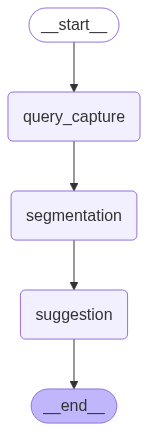

In [21]:
# Create the workflow graph
workflow = StateGraph(WorkflowState)

workflow.add_node("query_capture", query_capture_node)
workflow.add_node("segmentation", segmentation_node)
workflow.add_node("suggestion", suggestion_node)

workflow.set_entry_point("query_capture")
workflow.add_edge("query_capture", "segmentation")
workflow.add_edge("segmentation", "suggestion")
workflow.add_edge("suggestion", END)

# Visualize
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
# Function to run the workflow with a user query
def run_workflow(query: str):
    state = WorkflowState(query=query, context="", segment="", suggestion="")
    return app.invoke(state)

In [25]:
test_queries = [
    "I have an urgent issue with my order!",
    "I want to buy a new phone.",
    "What products do you offer?"
]

for query in test_queries:
    result = run_workflow(query)
    print(f"\n Query: {query}")
    print(f" Context:\n{result['context']}")
    print(f" Segment: {result['segment']}")
    print(f" Suggestion: {result['suggestion']}")



 Query: I have an urgent issue with my order!
 Context:
Human: I have an urgent issue with my order!
AI: Query received
Human: I have an urgent issue with my order!
AI: Query received
Human: I want to buy a new phone.
AI: Query received
Human: What products do you offer?
AI: Query received
User Query: I have an urgent issue with my order!
 Segment: High-Priority Customer
 Suggestion: Offer immediate support ticket escalation.

 Query: I want to buy a new phone.
 Context:
Human: I have an urgent issue with my order!
AI: Query received
Human: I have an urgent issue with my order!
AI: Query received
Human: I want to buy a new phone.
AI: Query received
Human: What products do you offer?
AI: Query received
Human: I have an urgent issue with my order!
AI: Query received
User Query: I want to buy a new phone.
 Segment: Potential Buyer
 Suggestion: Recommend our premium product with a 10% discount.

 Query: What products do you offer?
 Context:
Human: I have an urgent issue with my order!
AI:

In [ ]:
# Optional: view memory state
memory.load_memory_variables({})